# Data Science Project: Planning Stage (Individual)

## 1. Introduction

This year we have a unique opportunity: we have a real data science project with real stakeholders who are looking for answers to a few questions about their data.

In particular, a research group in Computer Science at UBC, led by Frank Wood, is collecting data about how people play video games. They have set up a MineCraft serverLinks to an external site., and players' actions are recorded as they navigate through the world. But running this project is not simple: they need to target their recruitment efforts, and make sure they have enough resources (e.g., software licenses, server hardware) to handle the number of players they attract.

### Question

Can player attributes like experience, gender, age, and played hours predict whether a player subscribes to newsletter?

### Data Description

My question relates player specific attributes to help predict if they subscribe to newsletter. For this reason, "players.csv" is required which contains a list of all unique players, including data about each player. There are 196 observations and 7 variables.
1. Experience: Categorical variable
2. Hashed Email: String (chars)
3. Played Hours: Quantitative variable
4. Name: String (chars)
5. Gender: Categorical variable
6. Age: Quantitative variable
7. Subscribe: Categorical Variable (what we wish to predict)

## 2. Methodology

### Import the required packages

In [28]:
library(tidyverse)
library(tidymodels)
library(janitor)

Load the dataset and produce short rows to explore kind of data.

In [29]:
players <- read_csv("data/players.csv")
head(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


As per the question's interest, we will focus on players dataset. 

Change the subscribe column to a categorical variable.

In [30]:
players <- players |> mutate(subscribe = as_factor(subscribe))
head(players)

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<fct>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


Count missing values per column - data cleaning

In [31]:
players |> summarize(across(everything(), ~ sum(is.na(.))))

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,2


We see that the Age column has 2 entries which are not integers. Clean the data by replacing the two NA entries with the mean value derived from the Age column. We don't replace specific to any other feature's selection (like experience level's mean because from initial data scan the experience level doesn't translate to played hours, giving no meaningful correlation to enhance on a singular feature's importance to predict ?subsribe)

In [32]:
players_clean <- players |> 
    clean_names() |>
    mutate(age = replace(age, is.na(age), mean(age, na.rm=TRUE)))

Perform Sanity check to ensure no missing column values

In [33]:
players_clean |> summarize(across(everything(), ~ sum(is.na(.))))

experience,subscribe,hashed_email,played_hours,name,gender,age
<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,0


In [34]:
head(players_clean)

experience,subscribe,hashed_email,played_hours,name,gender,age
<chr>,<fct>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


Compute the mean value for each quantitative variable in the players data set

In [35]:
summary(players_clean)

  experience        subscribe   hashed_email        played_hours    
 Length:196         FALSE: 52   Length:196         Min.   :  0.000  
 Class :character   TRUE :144   Class :character   1st Qu.:  0.000  
 Mode  :character               Mode  :character   Median :  0.100  
                                                   Mean   :  5.846  
                                                   3rd Qu.:  0.600  
                                                   Max.   :223.100  
     name              gender               age       
 Length:196         Length:196         Min.   : 9.00  
 Class :character   Class :character   1st Qu.:17.00  
 Mode  :character   Mode  :character   Median :19.50  
                                       Mean   :21.14  
                                       3rd Qu.:22.25  
                                       Max.   :58.00  

Report the mean values in a table format for each quantitative variable in the players data set

In [36]:
players_clean |>
    select(played_hours, age) |>
    summarize(across(everything(), ~ mean(.)))

played_hours,age
<dbl>,<dbl>
5.845918,21.13918


### We would like to visually inspect single variables for their representation

Distribution for player ages

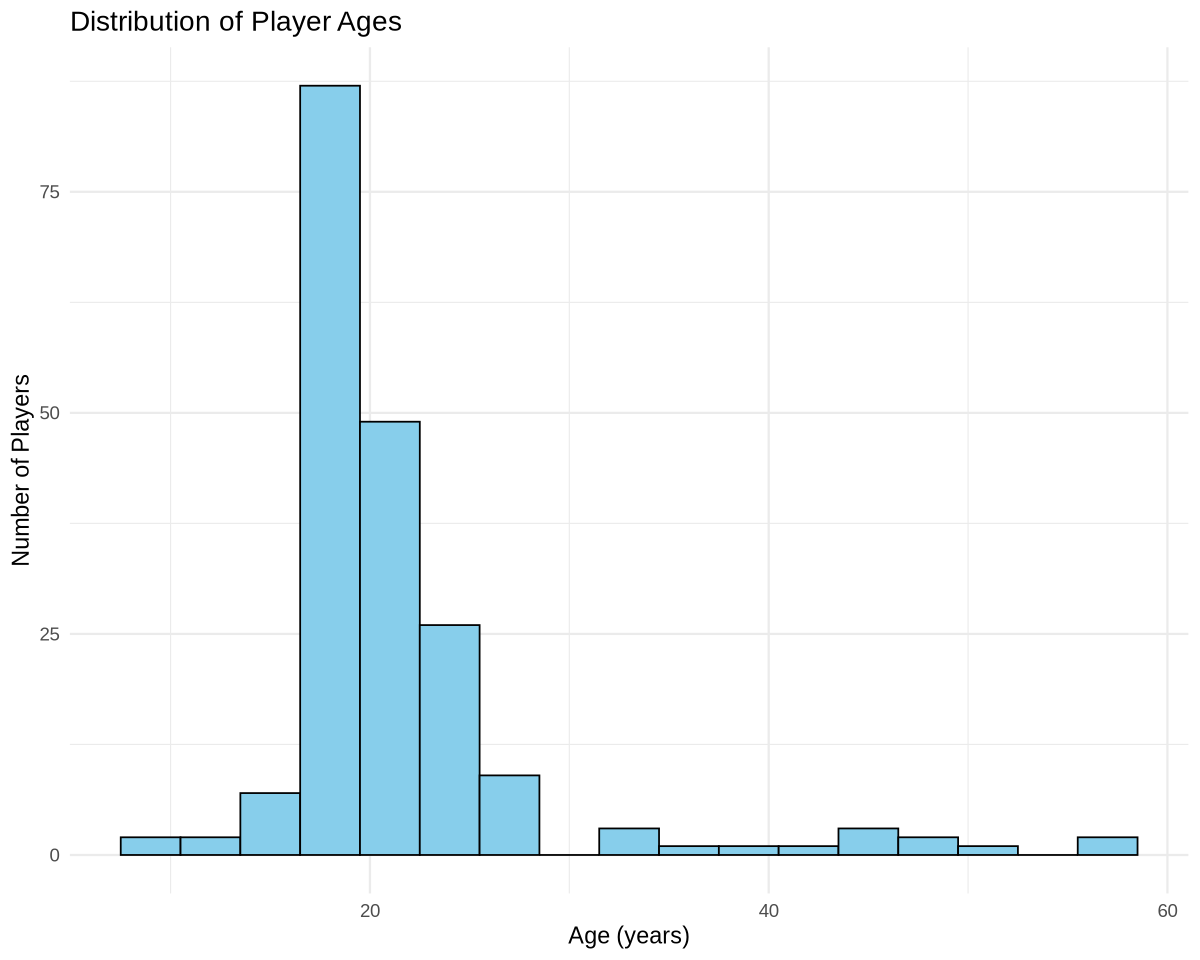

In [37]:
options(repr.plot.width = 10, repr.plot.height = 8)
theme_set(theme_minimal(base_size = 14))
age_plot <- players_clean |> 
    ggplot(aes(x=age)) +
    geom_histogram(binwidth=3, fill = "skyblue", color = "black") +
    labs(
        x="Age (years)",
        y="Number of Players",
        title="Distribution of Player Ages"
    )
age_plot

This shows that most of the players are young, aged 15-22.

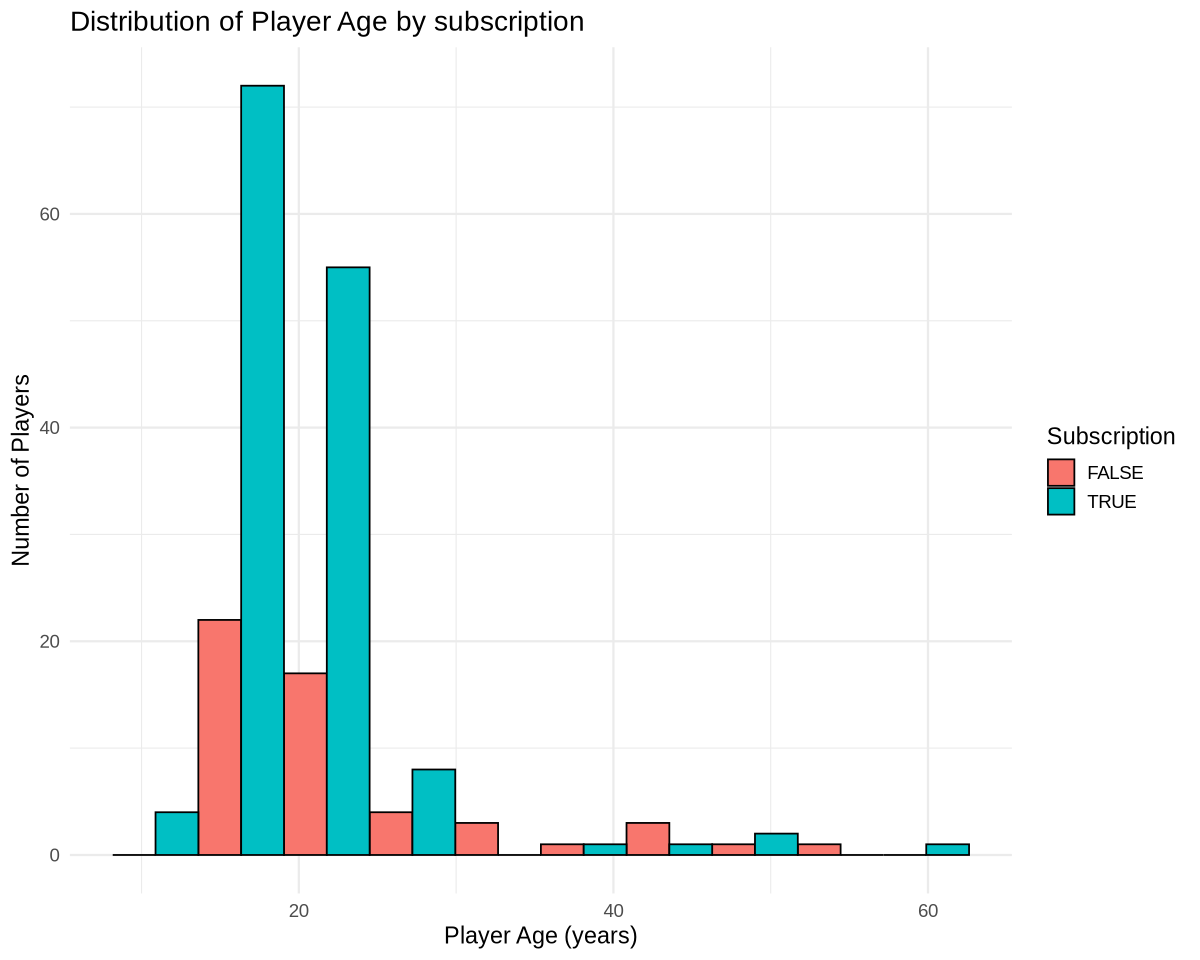

In [38]:
options(repr.plot.width = 10, repr.plot.height = 8)
age_subscription_plot <- players_clean |>
    ggplot(aes(x=age, fill=subscribe)) +
    geom_histogram(position = "dodge", bins = 10, color = "black") +
    labs(
        x="Player Age (years)",
        y="Number of Players",
        title="Distribution of Player Age by subscription",
        fill="Subscription"
    )
age_subscription_plot

Distribution of played hours

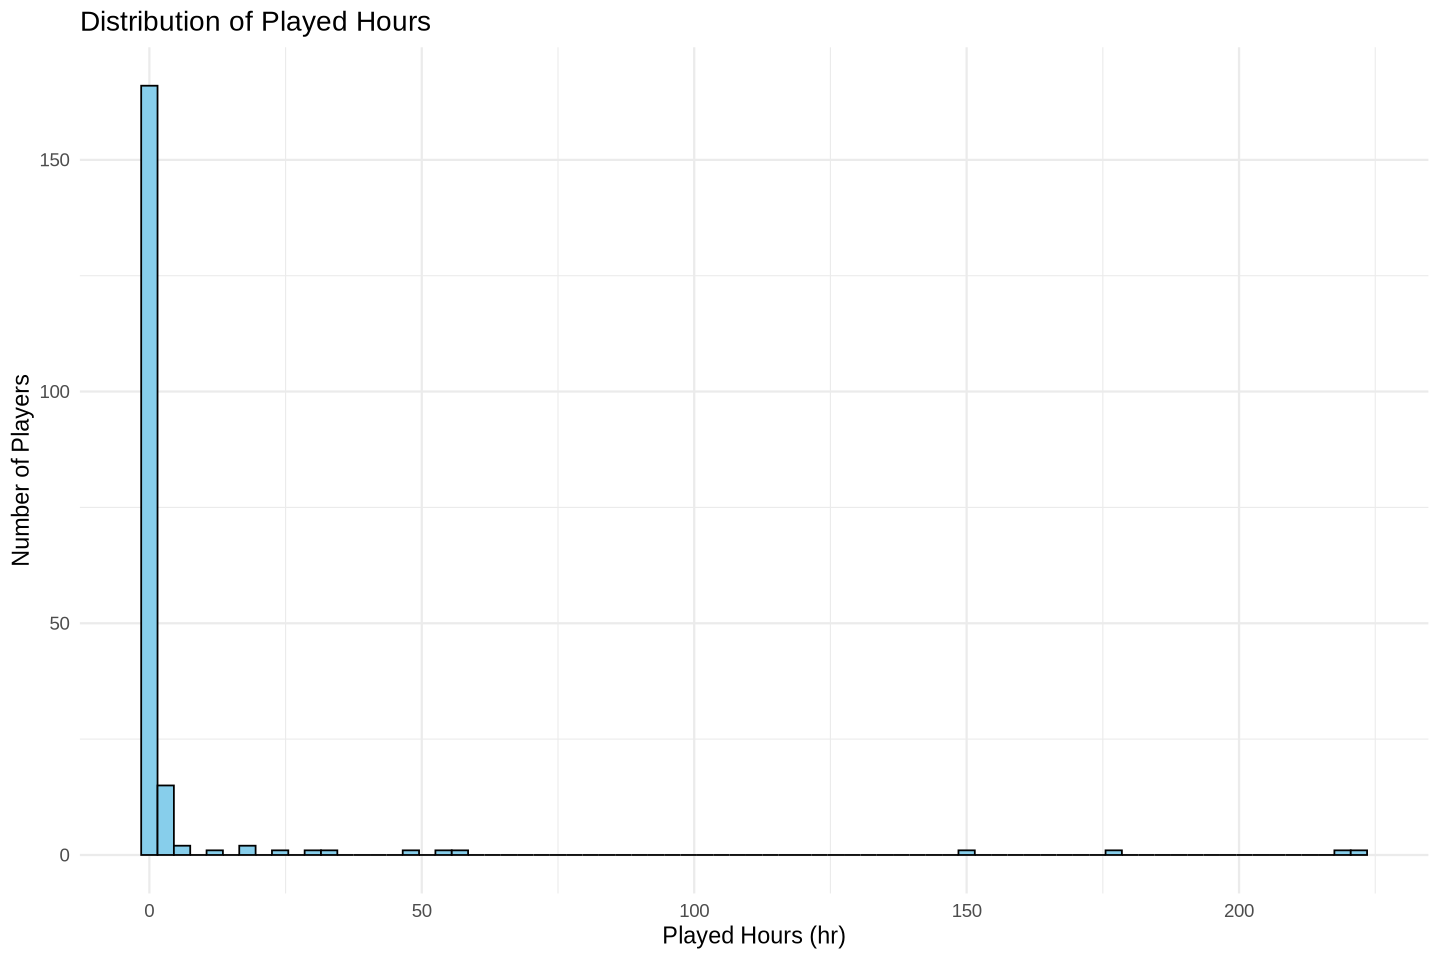

In [39]:
options(repr.plot.width = 12, repr.plot.height = 8)
theme_set(theme_minimal(base_size = 14))
played_hours_plot <- players_clean |> 
    ggplot(aes(x=played_hours)) +
    geom_histogram(binwidth=3, fill = "skyblue", color = "black") +
    labs(
        x="Played Hours (hr)",
        y="Number of Players",
        title="Distribution of Played Hours"
    )
played_hours_plot

This shows that the histogram is highly-skewed with most players playing only a few hours with a few outliers

### We would like to visually inspect how the proportion of feature variables are distributed for subscribed/not subscribed records

Subscription by Experience Level

In [40]:
players_clean |>
    group_by(experience, subscribe) |>
    summarize(count = n())

`summarise()` has grouped output by 'experience'. You can override using the
`.groups` argument.


experience,subscribe,count
<chr>,<fct>,<int>
Amateur,FALSE,18
Amateur,TRUE,45
Beginner,FALSE,8
Beginner,TRUE,27
Pro,FALSE,4
Pro,TRUE,10
Regular,FALSE,7
Regular,TRUE,29
Veteran,FALSE,15


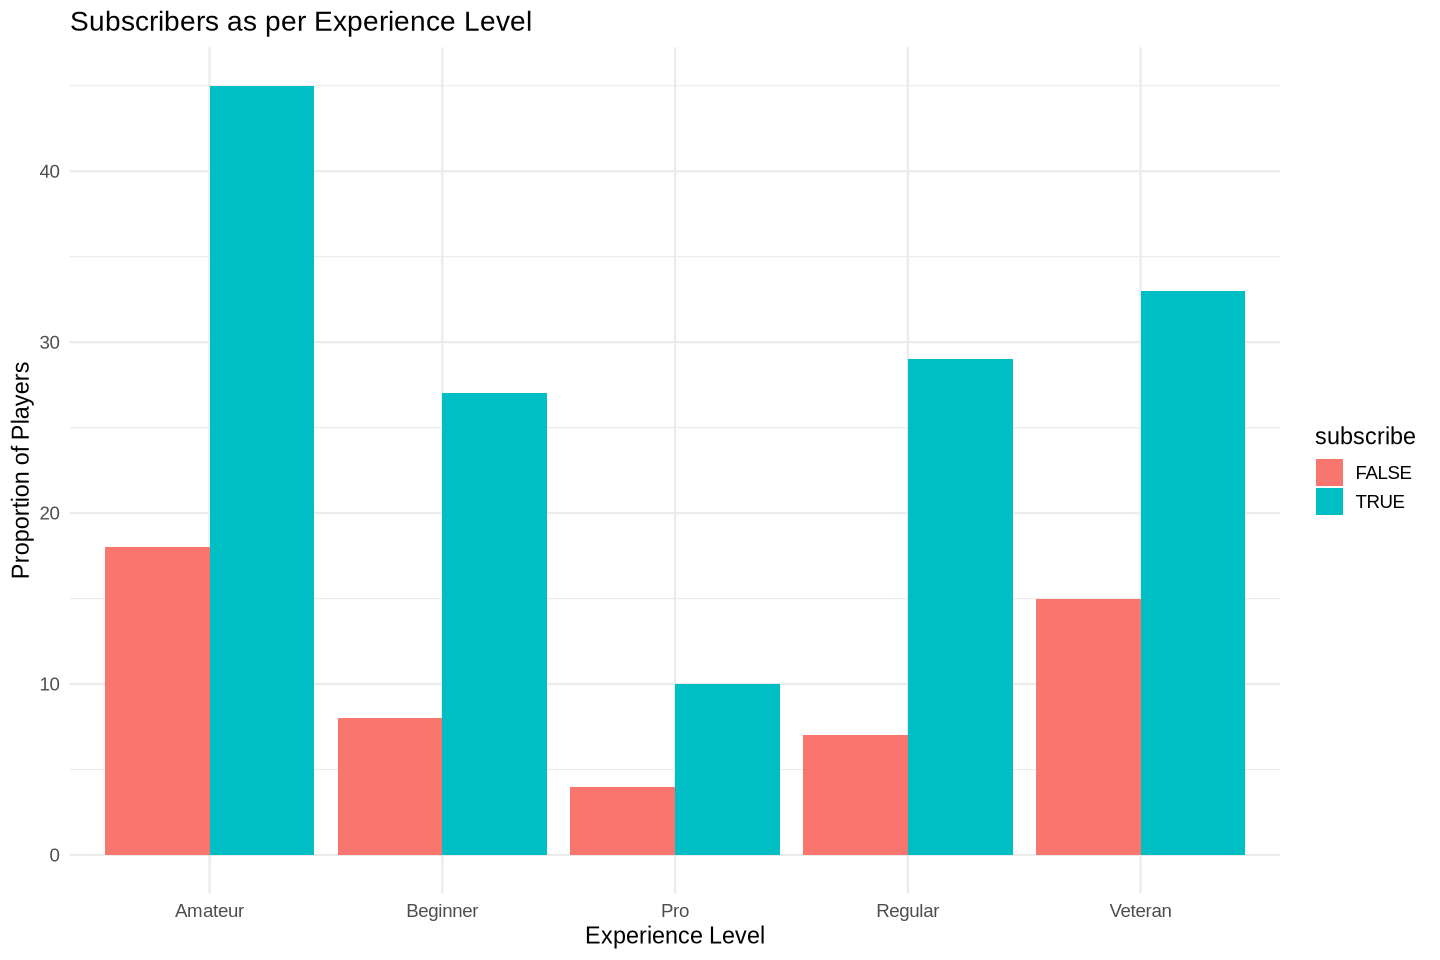

In [41]:
options(repr.plot.width = 12, repr.plot.height = 8)
subscription_plot <- players_clean |> 
    ggplot(aes(x=experience, fill=subscribe)) +
    geom_bar(position="dodge") +
    labs(
        x="Experience Level",
        y="Proportion of Players",
        title="Subscribers as per Experience Level"
    )
subscription_plot

The bar chart shows that the subscribers dominate across all experience categories.

Relation between age and played hours

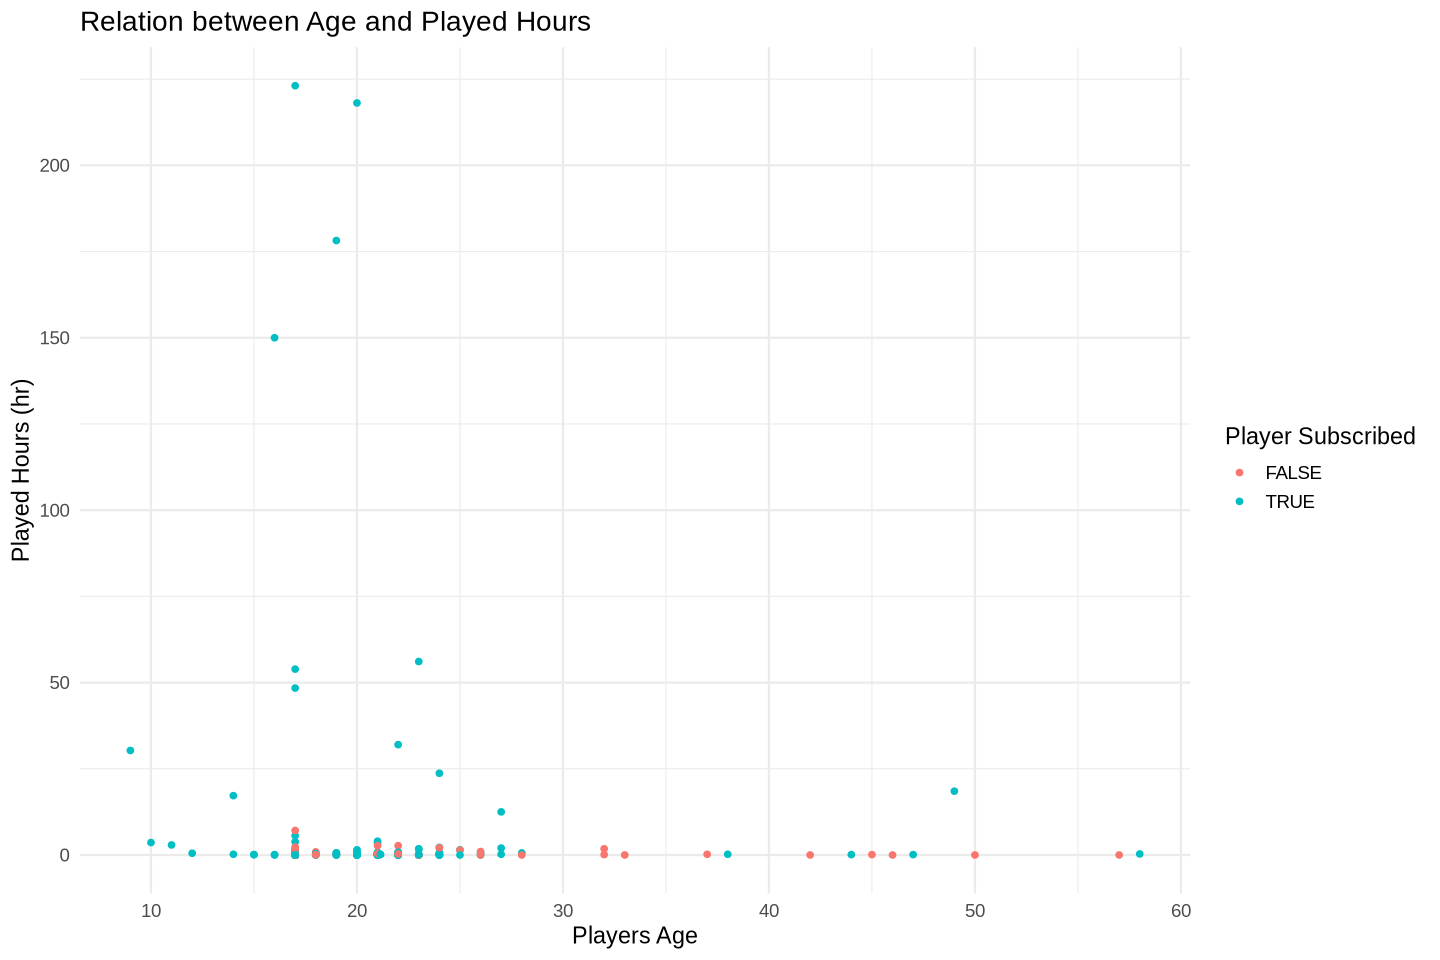

In [42]:
options(repr.plot.width = 12, repr.plot.height = 8)
age_played_time_plot <- players_clean |>
    ggplot(aes(x=age, y=played_hours, color=subscribe)) +
    geom_point() +
    labs(
        x="Players Age",
        y="Played Hours (hr)",
        title="Relation between Age and Played Hours",
        color="Player Subscribed"
    )
age_played_time_plot

The scatterplot shows no clear linear relationship between player age and played hours, but players aged 25 or less are more in number and show higher variation

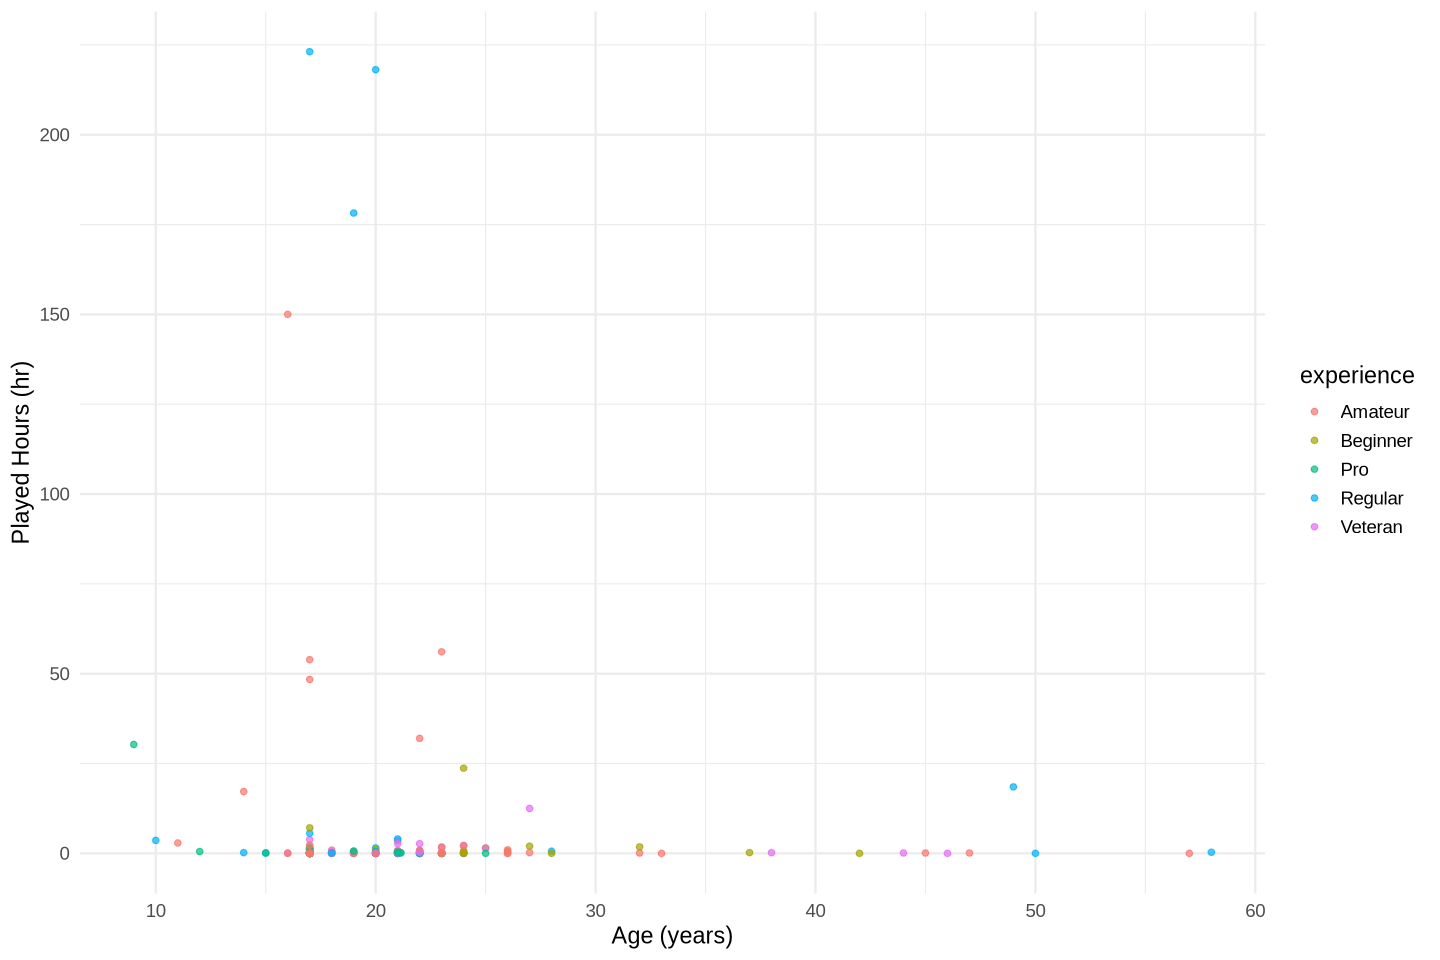

In [43]:
age_played_time_exp_plot <- players_clean |> 
    ggplot(aes(x = age, y = played_hours, color = experience)) +
    geom_point(alpha = 0.7) +
    labs(
    x = "Age (years)",
    y = "Played Hours (hr)"
  )
age_played_time_exp_plot

Gender vs Subscription

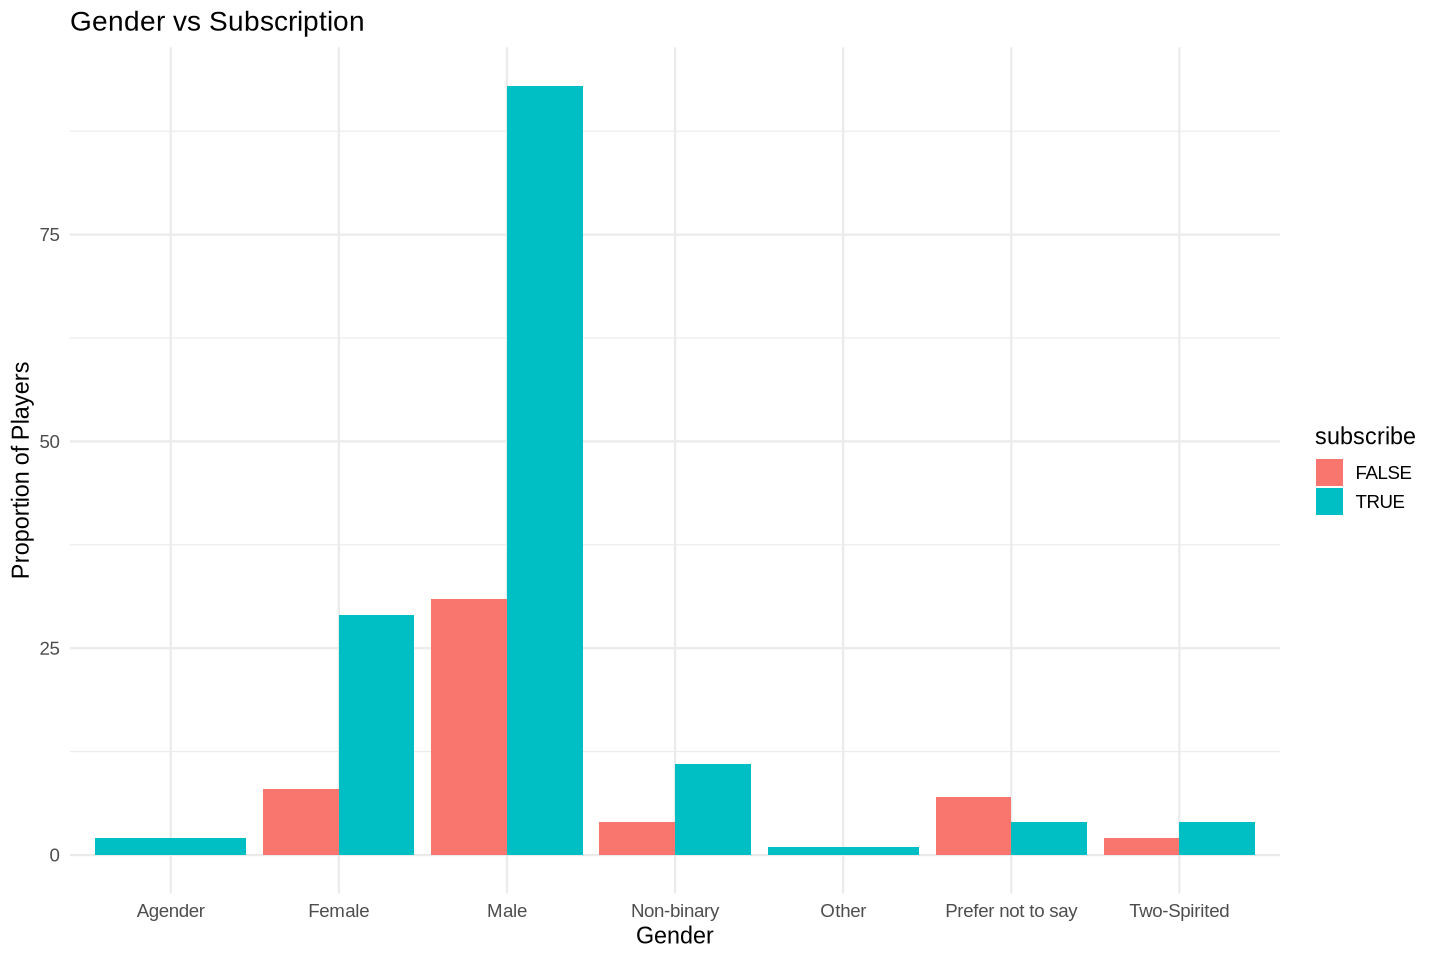

In [44]:
options(repr.plot.width = 12, repr.plot.height = 8)
gender_subscription_plot <- players_clean |>
    ggplot(aes(x=gender, fill=subscribe)) +
    geom_bar(position="dodge") +
    labs(
        x="Gender",
        y="Proportion of Players",
        title="Gender vs Subscription"
    )
gender_subscription_plot

The bar chart shows that male players are the largest group and also make most of the subscribers

Average played hours by experience

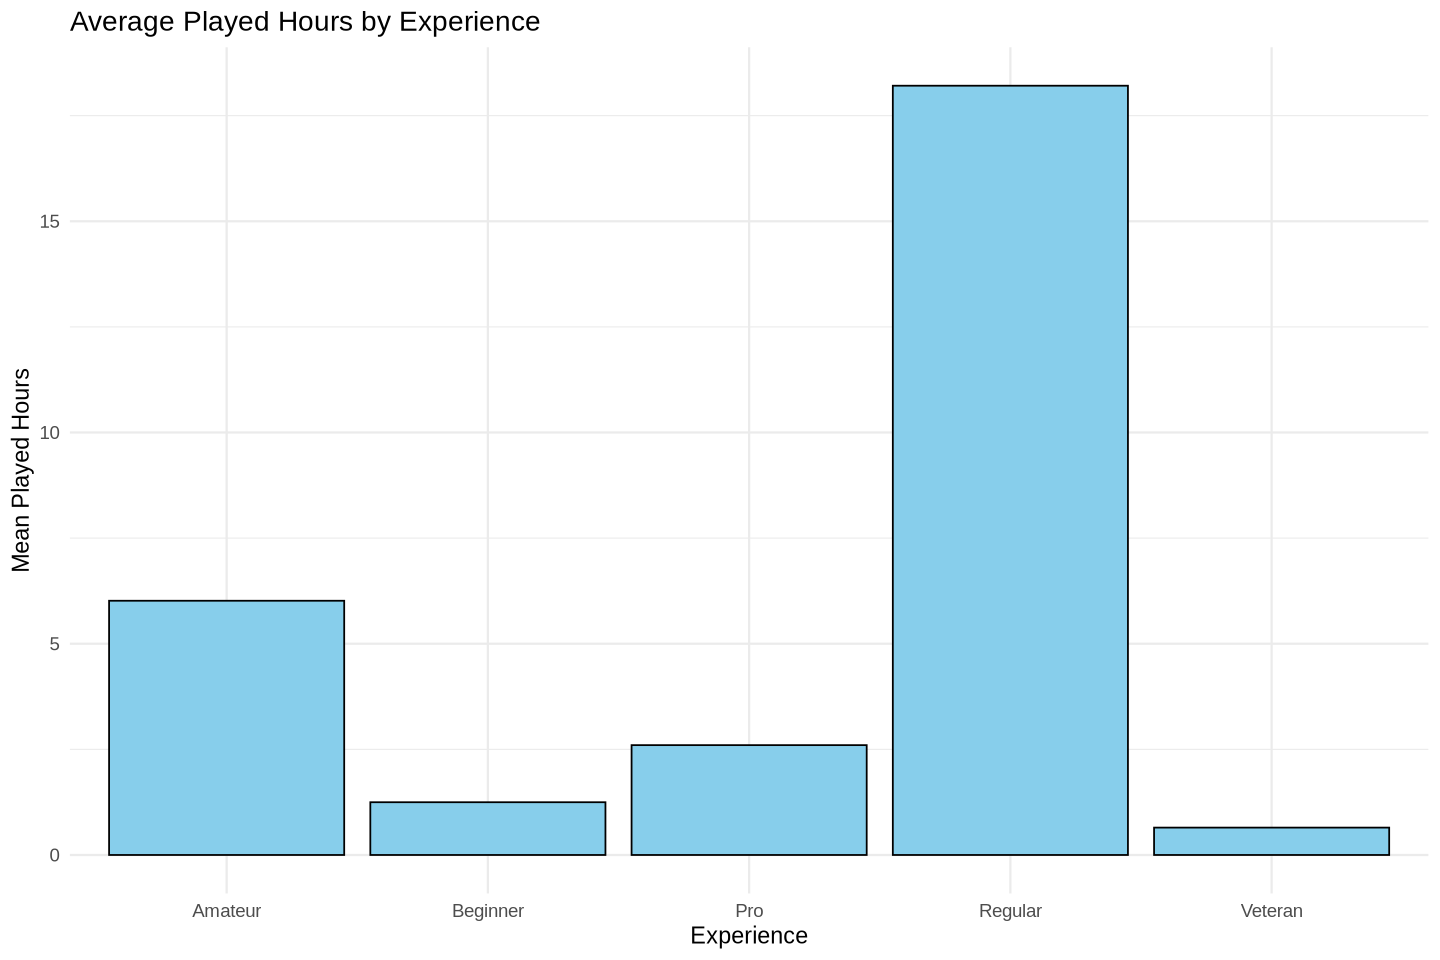

In [45]:
played_hours_experience_plot <- players_clean |>
    group_by(experience) |>
    summarize(mean_played_hours = mean(played_hours)) |>
    ggplot(aes(x=experience, y=mean_played_hours)) +
    geom_bar(stat="identity", fill="skyblue", color="black") +
    labs(
        x="Experience",
        y="Mean Played Hours",
        title="Average Played Hours by Experience"
    )
played_hours_experience_plot

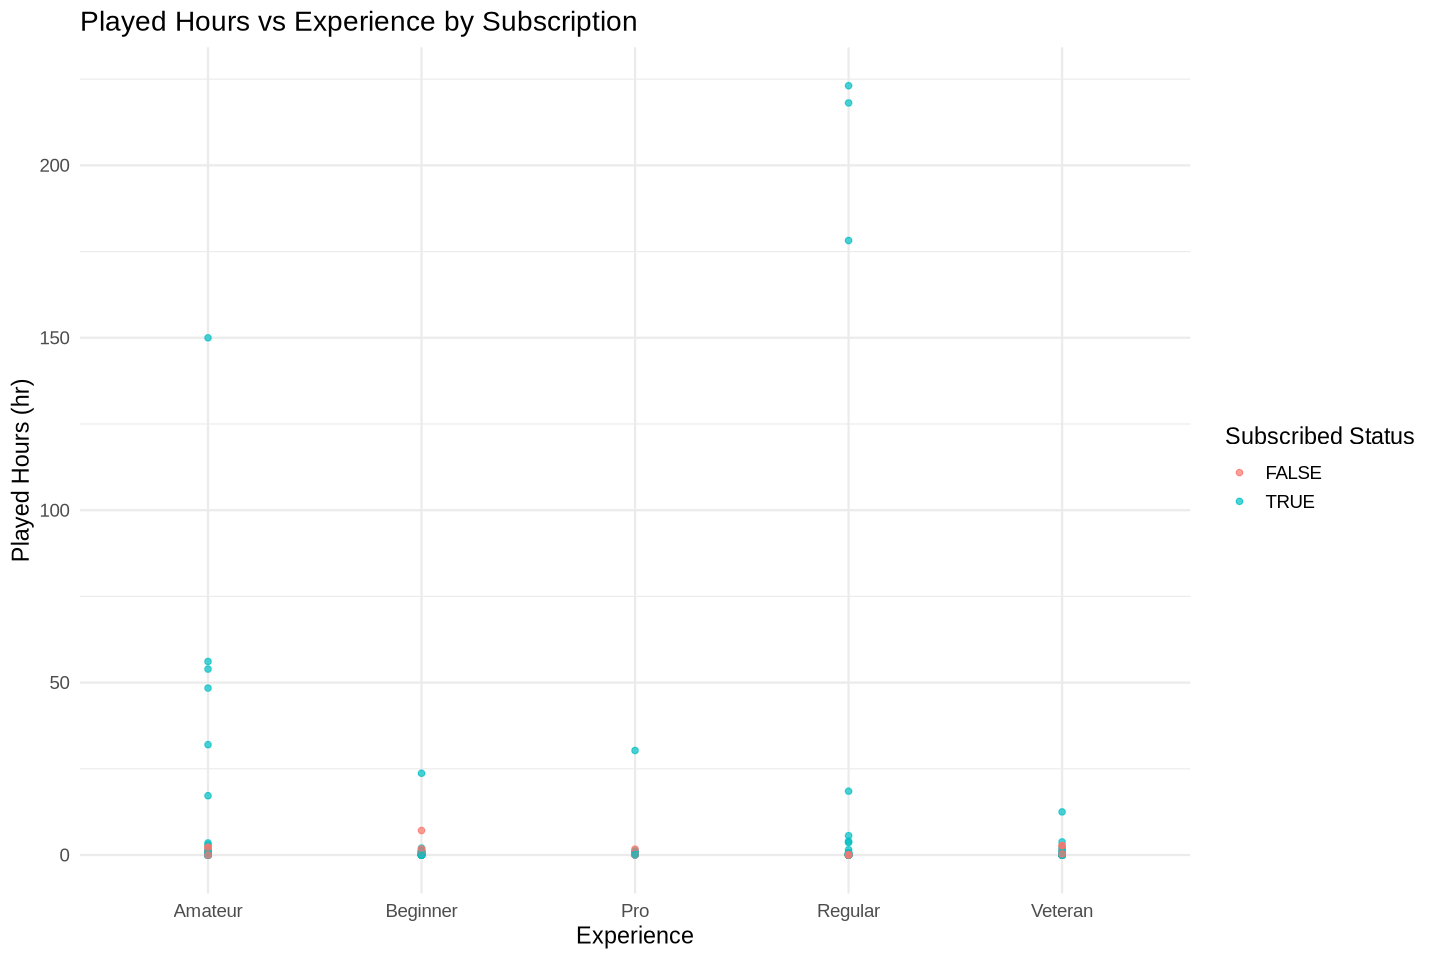

In [46]:
experience_played_hrs_subscribed_plot <- players_clean |>
    ggplot(aes(x=experience, y=played_hours, color=subscribe)) +
    geom_point(alpha=0.7) +
    labs(
        x="Experience",
        y="Played Hours (hr)",
        title="Played Hours vs Experience by Subscription",
        color="Subscribed Status"
    )
experience_played_hrs_subscribed_plot